In [276]:
import pandas as pd
import numpy as np
import os

print(os.getcwd())
# Load the file
df = pd.read_csv('../Gen_data/gen_hourly_MW_all.csv')
ptype = "Wind Onshore"
df = df[(df["Production Type"] == ptype)].copy()
df = df.rename(columns={
    "Generation (MW)": "Generation (MWh)"
})
# Check the first few rows
print(df.dtypes)
df.head()

E:\202510\2025-26-Data-driven\Prophet
datetime             object
Area                 object
Production Type      object
Generation (MWh)    float64
dtype: object


,datetime,Area,Production Type,Generation (MWh)
158144,2022-01-01 00:00:00,BZN|ES,Wind Onshore,6342.0
158145,2022-01-01 01:00:00,BZN|ES,Wind Onshore,6398.0
158146,2022-01-01 02:00:00,BZN|ES,Wind Onshore,6456.0
158147,2022-01-01 03:00:00,BZN|ES,Wind Onshore,6144.0
158148,2022-01-01 04:00:00,BZN|ES,Wind Onshore,5943.0


In [277]:
# Convert datetime column to proper datetime format
df['ds'] = pd.to_datetime(df['datetime'])

# Rename the generation column for Prophet (use the MWh column name)
df['y'] = df['Generation (MWh)']

# Keep only the necessary columns
df = df[['ds', 'y']].sort_values('ds')

print(df.dtypes)
print(df.head())
print(f"\nData range: {df['ds'].min()} to {df['ds'].max()}")
print(f"Total records: {len(df)}")

ds    datetime64[ns]
y            float64
dtype: object
                        ds       y
158144 2022-01-01 00:00:00  6342.0
158145 2022-01-01 01:00:00  6398.0
158146 2022-01-01 02:00:00  6456.0
158147 2022-01-01 03:00:00  6144.0
158148 2022-01-01 04:00:00  5943.0

Data range: 2022-01-01 00:00:00 to 2024-12-31 23:00:00
Total records: 26301


## month 2022-24

In [278]:
# create new relevant variables or filters when useful
df['ds'] = pd.to_datetime(df['ds'], format='%Y/%m/%d %H:%M:%S')
df['year'] = df['ds'].dt.year
df['month'] = df['ds'].dt.month
df['day'] = df['ds'].dt.day
df['weekday'] = df['ds'].dt.day_name()  # weekdays
df['is_weekend'] = df['ds'].dt.dayofweek >= 5  # True = weekends
df['season'] = df['ds'].dt.quarter  # season 1-4
# def seasons function
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'

# apply season
df['season'] = df['month'].apply(get_season)

# Filter data for March to September only (months 3-9)
df = df[(df['month'] >= 1) & (df['month'] <= 12)].copy()

print(f"Filtered data for March to September:")
print(f"  Period: {df['ds'].min()} to {df['ds'].max()}")
print(f"  Total records: {len(df)}")
print(f"  Years covered: {sorted(df['year'].unique())}")

df[df['season'] == 'Summer'].head()

Filtered data for March to September:
  Period: 2022-01-01 00:00:00 to 2024-12-31 23:00:00
  Total records: 26301
  Years covered: [2022, 2023, 2024]


,ds,y,year,month,day,weekday,is_weekend,season
161767,2022-06-01 00:00:00,3090.0,2022,6,1,Wednesday,False,Summer
161768,2022-06-01 01:00:00,3297.0,2022,6,1,Wednesday,False,Summer
161769,2022-06-01 02:00:00,3487.0,2022,6,1,Wednesday,False,Summer
161770,2022-06-01 03:00:00,3693.0,2022,6,1,Wednesday,False,Summer
161771,2022-06-01 04:00:00,3694.0,2022,6,1,Wednesday,False,Summer


In [279]:
# Data quality check and outlier detection
print("Data Quality Analysis:")
print("=" * 60)

# Check for missing values
missing_count = df['y'].isna().sum()
print(f"Missing values: {missing_count}")

# Check for negative values (shouldn't exist for solar generation)
negative_count = (df['y'] < 0).sum()
print(f"Negative values: {negative_count}")

# Detect outliers using IQR method
Q1 = df['y'].quantile(0.25)
Q3 = df['y'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 3 * IQR  # 3*IQR for extreme outliers
upper_bound = Q3 + 3 * IQR

outliers = ((df['y'] < lower_bound) | (df['y'] > upper_bound)).sum()
print(f"Outliers detected (3*IQR method): {outliers}")

# Show basic statistics
print(f"\nGeneration statistics:")
print(f"  Min: {df['y'].min():.2f} MWh")
print(f"  Max: {df['y'].max():.2f} MWh")
print(f"  Mean: {df['y'].mean():.2f} MWh")
print(f"  Median: {df['y'].median():.2f} MWh")
print(f"  Std: {df['y'].std():.2f} MWh")
print(f"  95th percentile: {df['y'].quantile(0.95):.2f} MWh")
print(f"  99th percentile: {df['y'].quantile(0.99):.2f} MWh")

# Cap extreme outliers to reasonable maximum
df_cleaned = df.copy()
max_reasonable = df['y'].quantile(0.99) * 1.1  # 110% of 99th percentile
df_cleaned.loc[df_cleaned['y'] > max_reasonable, 'y'] = max_reasonable
df_cleaned.loc[df_cleaned['y'] < 0, 'y'] = 0  # Remove any negative values

capped_count = (df['y'] != df_cleaned['y']).sum()
print(f"\nCapped {capped_count} extreme values to max: {max_reasonable:.2f} MWh")
print("Data is ready for modeling")

# Update df with cleaned data
df = df_cleaned

Data Quality Analysis:
Missing values: 0
Negative values: 0
Outliers detected (3*IQR method): 0

Generation statistics:
  Min: 190.00 MWh
  Max: 20718.00 MWh
  Mean: 6800.48 MWh
  Median: 6102.00 MWh
  Std: 3949.71 MWh
  95th percentile: 14380.00 MWh
  99th percentile: 17227.00 MWh

Capped 35 extreme values to max: 18949.70 MWh
Data is ready for modeling


In [280]:
wind_df = pd.read_csv("../Gen_data/Wind_2022_2024.csv")

## season factor


In [281]:
# Split data into train (70%), validation (20%), and test (10%)
# Using only March to September data from 2022-2024
total_rows = len(df)
train_size = int(0.7 * total_rows)
val_size = int(0.2 * total_rows)

train_df = df.iloc[:train_size].copy()
val_df = df.iloc[train_size:train_size + val_size].copy()
test_df = df.iloc[train_size + val_size:].copy()

def add_wind_regressor(df, wind_df):
    df['ds'] = pd.to_datetime(df['ds'])
    wind_df['hourly__time'] = pd.to_datetime(wind_df['hourly__time'])

    merged = pd.merge_asof(
        df.sort_values('ds'),
        wind_df.sort_values('hourly__time'),
        left_on='ds',
        right_on='hourly__time',
        direction='nearest',
        tolerance=pd.Timedelta('30min')
    )

    # Time
    merged['hour'] = merged['ds'].dt.hour
    merged['month'] = merged['ds'].dt.month

    # wind_speed_cubed, Power is proportional to wind speed^3
    merged['wind_speed_cubed'] = merged['hourly__wind_speed_100m'] ** 3

    # wind_direction
    wind_dir_rad = np.deg2rad(merged['hourly__wind_direction_100m'])
    merged['wind_direction_sin'] = np.sin(wind_dir_rad)
    merged['wind_direction_cos'] = np.cos(wind_dir_rad)

    '''# On average across Spain:
    # Wind energy is stronger in spring (March to May) and winter (November to February)
    # Weaker in summer (June to August).
    merged['season_factor'] = (
        0.5 * (np.cos((merged['month'] - 2) / 12 * 2 * np.pi) ** 2) +
        0.5 * (np.cos((merged['month'] - 12) / 12 * 2 * np.pi) ** 2)
    )
    # unified to [0,1]
    merged['season_factor'] = (merged['season_factor'] - merged['season_factor'].min()) / \
                              (merged['season_factor'].max() - merged['season_factor'].min())'''
    # 使用更符合西班牙风能分布的季节因子
    def calculate_season_factor(month):
        # 根据西班牙地理条件调整
        if month in [12, 1, 2, 3, 4]:  # 冬春季节风能较强
            return 2
        elif month in [5, 6, 7]:       # 夏季风能中等
            return 1.4
        elif month in [8, 9, 10, 11]:  # 秋季风能较弱
            return 1
        else:
            return 1.4

    merged['season_factor'] = merged['month'].apply(calculate_season_factor)


    merged['wind_potential_index'] = (
        merged['wind_speed_cubed'] * merged['season_factor']
    )

    return merged

train_df = add_wind_regressor(train_df, wind_df)
val_df = add_wind_regressor(val_df, wind_df)
test_df = add_wind_regressor(test_df, wind_df)

print(f"Dataset: March to September (2022-2024)")
print(f"Total data points: {total_rows}")
print(f"\nTraining set: {len(train_df)} records ({len(train_df)/total_rows*100:.1f}%)")
print(f"  Period: {train_df['ds'].min()} to {train_df['ds'].max()}")
print(f"\nValidation set: {len(val_df)} records ({len(val_df)/total_rows*100:.1f}%)")
print(f"  Period: {val_df['ds'].min()} to {val_df['ds'].max()}")
print(f"\nTest set: {len(test_df)} records ({len(test_df)/total_rows*100:.1f}%)")
print(f"  Period: {test_df['ds'].min()} to {test_df['ds'].max()}")

# Show wind data by hour
print(f"\nWind Pattern (sample):")
hourly_elevation = train_df.groupby('hour')['wind_potential_index'].mean().reset_index()
for _, row in hourly_elevation.iterrows():
    print(f"  Hour {int(row['hour']):02d}:00 - wind_potential_index: {row['wind_potential_index']:.3f}")

Dataset: March to September (2022-2024)
Total data points: 26301

Training set: 18410 records (70.0%)
  Period: 2022-01-01 00:00:00 to 2024-02-07 03:00:00

Validation set: 5260 records (20.0%)
  Period: 2024-02-07 04:00:00 to 2024-09-13 08:00:00

Test set: 2631 records (10.0%)
  Period: 2024-09-13 09:00:00 to 2024-12-31 23:00:00

Wind Pattern (sample):
  Hour 00:00 - wind_potential_index: 9623.932
  Hour 01:00 - wind_potential_index: 10423.645
  Hour 02:00 - wind_potential_index: 10195.259
  Hour 03:00 - wind_potential_index: 10386.627
  Hour 04:00 - wind_potential_index: 10715.936
  Hour 05:00 - wind_potential_index: 11356.609
  Hour 06:00 - wind_potential_index: 12339.764
  Hour 07:00 - wind_potential_index: 12869.373
  Hour 08:00 - wind_potential_index: 12754.989
  Hour 09:00 - wind_potential_index: 12632.805
  Hour 10:00 - wind_potential_index: 12630.849
  Hour 11:00 - wind_potential_index: 11674.439
  Hour 12:00 - wind_potential_index: 11571.473
  Hour 13:00 - wind_potential_index

In [282]:
train_df.describe

<bound method NDFrame.describe of                        ds        y  year  month  day    weekday  is_weekend  \
0     2022-01-01 00:00:00   6342.0  2022      1    1   Saturday        True   
1     2022-01-01 01:00:00   6398.0  2022      1    1   Saturday        True   
2     2022-01-01 02:00:00   6456.0  2022      1    1   Saturday        True   
3     2022-01-01 03:00:00   6144.0  2022      1    1   Saturday        True   
4     2022-01-01 04:00:00   5943.0  2022      1    1   Saturday        True   
...                   ...      ...   ...    ...  ...        ...         ...   
18405 2024-02-06 23:00:00  10208.0  2024      2    6    Tuesday       False   
18406 2024-02-07 00:00:00  10058.0  2024      2    7  Wednesday       False   
18407 2024-02-07 01:00:00  10115.0  2024      2    7  Wednesday       False   
18408 2024-02-07 02:00:00  10316.0  2024      2    7  Wednesday       False   
18409 2024-02-07 03:00:00  10578.0  2024      2    7  Wednesday       False   

       season    

In [283]:
from prophet import Prophet
import matplotlib.pyplot as plt

# Build Prophet Model
model = Prophet(
    # Basic seasonal
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True,

    # Regularization parameters (prevent overfitting)
    changepoint_prior_scale=0.05,    # Higher value for more varies
    seasonality_prior_scale=10.0,    # Enable more-flexable seasonal change

    # Changepoint settings
    changepoint_range=0.85,
    n_changepoints=20,

    # Seasonality mode
    seasonality_mode='additive',     # additive

    # Interval width
    interval_width=0.9,

    # Growth model
    growth='linear',

    # Other settings
    mcmc_samples=0,
    uncertainty_samples=1000
)

# multiplicative
model.add_regressor('wind_potential_index', mode='multiplicative')

# 添加底值约束（风电发电量不能为负）
train_df['floor'] = 0

# Train
print("Training Prophet model for wind power forecasting...")
print("=" * 60)
print("Model Configuration:")
print(f"  - Growth: {model.growth}")
print(f"  - Changepoint prior scale: {model.changepoint_prior_scale}")
print(f"  - Seasonality prior scale: {model.seasonality_prior_scale}")
print(f"  - Seasonality mode: {model.seasonality_mode}")
print(f"  - Floor constraint: 0 (no negative values)")
print(f"  - Custom regressor: wind_potential_index (multiplicative)")
print("=" * 60)

model.fit(train_df)

print("\nTraining complete!")


Training Prophet model for wind power forecasting...
Model Configuration:
  - Growth: linear
  - Changepoint prior scale: 0.05
  - Seasonality prior scale: 10.0
  - Seasonality mode: additive
  - Floor constraint: 0 (no negative values)
  - Custom regressor: wind_potential_index (multiplicative)


17:57:28 - cmdstanpy - INFO - Chain [1] start processing
17:57:30 - cmdstanpy - INFO - Chain [1] done processing



Training complete!


In [284]:
# Validate model on validation set
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Predict on validation data (add floor constraint and solar elevation regressor)
val_df_pred = val_df.copy()
val_df_pred['floor'] = 0
val_forecast = model.predict(val_df_pred[['ds', 'floor', 'wind_potential_index']])

# Clip predictions to non-negative values (safety check)
val_forecast['yhat'] = val_forecast['yhat'].clip(lower=0)
val_forecast['yhat_lower'] = val_forecast['yhat_lower'].clip(lower=0)
val_forecast['yhat_upper'] = val_forecast['yhat_upper'].clip(lower=0)

# Reset indices to align properly
val_actual = val_df['y'].values
val_pred = val_forecast['yhat'].values

# Calculate validation metrics
val_mae = mean_absolute_error(val_actual, val_pred)
val_rmse = np.sqrt(mean_squared_error(val_actual, val_pred))

# Calculate MAPE excluding very small values (< 10 MWh threshold for meaningful generation)
# This filters out nighttime and very low generation periods
threshold = 10  # MWh
significant_mask = val_actual >= threshold
if significant_mask.sum() > 0:
    val_mape = np.mean(np.abs((val_actual[significant_mask] - val_pred[significant_mask]) / val_actual[significant_mask])) * 100
else:
    val_mape = np.nan

print("Validation Set Performance:")
print("=" * 50)
print(f"MAE:  {val_mae:.2f} MWh")
print(f"RMSE: {val_rmse:.2f} MWh")
if not np.isnan(val_mape):
    print(f"MAPE (generation >= {threshold} MWh): {val_mape:.2f}%")
else:
    print(f"MAPE: N/A")

# Show additional info
zero_count = (val_actual == 0).sum()
low_gen_count = ((val_actual > 0) & (val_actual < threshold)).sum()
print(f"\nData distribution in validation set:")
print(f"  Zero values: {zero_count} ({zero_count/len(val_actual)*100:.1f}%)")
print(f"  Low generation (0-{threshold} MWh): {low_gen_count} ({low_gen_count/len(val_actual)*100:.1f}%)")
print(f"  Significant generation (>={threshold} MWh): {significant_mask.sum()} ({significant_mask.sum()/len(val_actual)*100:.1f}%)")

# Check prediction range
print(f"\nPrediction range:")
print(f"  Min: {val_pred.min():.2f} MWh")
print(f"  Max: {val_pred.max():.2f} MWh")
print(f"  Mean: {val_pred.mean():.2f} MWh")


Validation Set Performance:
MAE:  4076.75 MWh
RMSE: 4867.71 MWh
MAPE (generation >= 10 MWh): 68.94%

Data distribution in validation set:
  Zero values: 0 (0.0%)
  Low generation (0-10 MWh): 0 (0.0%)
  Significant generation (>=10 MWh): 5260 (100.0%)

Prediction range:
  Min: 0.00 MWh
  Max: 14466.38 MWh
  Mean: 2893.58 MWh


In [285]:
# Test model on test set
test_df_pred = test_df.copy()
test_df_pred['floor'] = 0
test_forecast = model.predict(test_df_pred[['ds', 'floor', 'wind_potential_index']])

# Clip predictions to non-negative values (safety check)
test_forecast['yhat'] = test_forecast['yhat'].clip(lower=0)
test_forecast['yhat_lower'] = test_forecast['yhat_lower'].clip(lower=0)
test_forecast['yhat_upper'] = test_forecast['yhat_upper'].clip(lower=0)

# Reset indices to align properly
test_actual = test_df['y'].values
test_pred = test_forecast['yhat'].values

# Calculate test metrics
test_mae = mean_absolute_error(test_actual, test_pred)
test_rmse = np.sqrt(mean_squared_error(test_actual, test_pred))

# Calculate MAPE excluding very small values (< 10 MWh threshold)
threshold = 10  # MWh
significant_mask = test_actual >= threshold
if significant_mask.sum() > 0:
    test_mape = np.mean(np.abs((test_actual[significant_mask] - test_pred[significant_mask]) / test_actual[significant_mask])) * 100
else:
    test_mape = np.nan

print("Test Set Performance:")
print("=" * 50)
print(f"MAE:  {test_mae:.2f} MWh")
print(f"RMSE: {test_rmse:.2f} MWh")
if not np.isnan(test_mape):
    print(f"MAPE (generation >= {threshold} MWh): {test_mape:.2f}%")
else:
    print(f"MAPE: N/A")

# Show additional info
zero_count = (test_actual == 0).sum()
low_gen_count = ((test_actual > 0) & (test_actual < threshold)).sum()
print(f"\nData distribution in test set:")
print(f"  Zero values: {zero_count} ({zero_count/len(test_actual)*100:.1f}%)")
print(f"  Low generation (0-{threshold} MWh): {low_gen_count} ({low_gen_count/len(test_actual)*100:.1f}%)")
print(f"  Significant generation (>={threshold} MWh): {significant_mask.sum()} ({significant_mask.sum()/len(test_actual)*100:.1f}%)")

# Check prediction range
print(f"\nPrediction range:")
print(f"  Min: {test_pred.min():.2f} MWh")
print(f"  Max: {test_pred.max():.2f} MWh")
print(f"  Mean: {test_pred.mean():.2f} MWh")

Test Set Performance:
MAE:  5647.55 MWh
RMSE: 7098.66 MWh
MAPE (generation >= 10 MWh): 76.41%

Data distribution in test set:
  Zero values: 0 (0.0%)
  Low generation (0-10 MWh): 0 (0.0%)
  Significant generation (>=10 MWh): 2631 (100.0%)

Prediction range:
  Min: 0.00 MWh
  Max: 5474.64 MWh
  Mean: 1515.41 MWh


In [286]:
# Load actual 2025 data for comparison
df_2025 = pd.read_csv("../Gen_data/Wind_Onshore_hourly_2025.csv")
df_2025['ds'] = pd.to_datetime(df_2025['datetime'])
df_2025['y'] = df_2025['Generation (MWh)']
df_2025

,datetime,Area,Production Type,Generation (MWh),ds,y
0,2025/1/1 0:00,BZN|ES,Wind Onshore,2949.0,2025-01-01 00:00:00,2949.0
1,2025/1/1 1:00,BZN|ES,Wind Onshore,3222.0,2025-01-01 01:00:00,3222.0
2,2025/1/1 2:00,BZN|ES,Wind Onshore,3428.0,2025-01-01 02:00:00,3428.0
3,2025/1/1 3:00,BZN|ES,Wind Onshore,3526.0,2025-01-01 03:00:00,3526.0
4,2025/1/1 4:00,BZN|ES,Wind Onshore,3609.0,2025-01-01 04:00:00,3609.0
...,...,...,...,...,...,...
8755,2025/12/31 19:00,BZN|ES,Wind Onshore,0.0,2025-12-31 19:00:00,0.0
8756,2025/12/31 20:00,BZN|ES,Wind Onshore,0.0,2025-12-31 20:00:00,0.0
8757,2025/12/31 21:00,BZN|ES,Wind Onshore,0.0,2025-12-31 21:00:00,0.0
8758,2025/12/31 22:00,BZN|ES,Wind Onshore,0.0,2025-12-31 22:00:00,0.0


In [287]:
df_2025['month'] = df_2025['ds'].dt.month
df_2025 = df_2025[(df_2025['month'] >= 1) & (df_2025['month'] <= 9)].copy()

wind_df1 = pd.read_csv("../Gen_data/Wind_2025_1.csv")
# Create future dataframe with regressor
future_2025 = df_2025[['ds']].copy()
future_2025['floor'] = 0
future_2025 = add_wind_regressor(future_2025,wind_df1)

future_2025.describe

<bound method NDFrame.describe of                       ds  floor        hourly__time  \
0    2025-01-01 00:00:00      0 2025-01-01 00:00:00   
1    2025-01-01 01:00:00      0 2025-01-01 01:00:00   
2    2025-01-01 02:00:00      0 2025-01-01 02:00:00   
3    2025-01-01 03:00:00      0 2025-01-01 03:00:00   
4    2025-01-01 04:00:00      0 2025-01-01 04:00:00   
...                  ...    ...                 ...   
6547 2025-09-30 19:00:00      0 2025-09-30 19:00:00   
6548 2025-09-30 20:00:00      0 2025-09-30 20:00:00   
6549 2025-09-30 21:00:00      0 2025-09-30 21:00:00   
6550 2025-09-30 22:00:00      0 2025-09-30 22:00:00   
6551 2025-09-30 23:00:00      0 2025-09-30 23:00:00   

      hourly__apparent_temperature  hourly__wind_speed_100m  \
0                             -4.3                     10.8   
1                             -3.5                     11.1   
2                             -4.3                     14.4   
3                             -2.6                   

In [288]:


# Make predictions
forecast_2025 = model.predict(future_2025)

# Clip predictions to non-negative values
forecast_2025['yhat'] = forecast_2025['yhat'].clip(lower=0)
forecast_2025['yhat_lower'] = forecast_2025['yhat_lower'].clip(lower=0)
forecast_2025['yhat_upper'] = forecast_2025['yhat_upper'].clip(lower=0)

# Calculate metrics for 2025 forecast
actual_2025 = df_2025['y'].values
pred_2025 = forecast_2025['yhat'].values

mae_2025 = mean_absolute_error(actual_2025, pred_2025)
rmse_2025 = np.sqrt(mean_squared_error(actual_2025, pred_2025))
mape_2025 = np.mean(np.abs((actual_2025 - pred_2025) / (actual_2025 + 1e-8))) * 100

print(f"2025 Forecast Performance (March-September): MAE={mae_2025:.2f} MWh, RMSE={rmse_2025:.2f} MWh, MAPE={mape_2025:.2f}%")


2025 Forecast Performance (March-September): MAE=5904.16 MWh, RMSE=6860.52 MWh, MAPE=98.07%


In [289]:
# Analyze hourly patterns with wind potential for 2025 forecast
df_2025['hour'] = df_2025['ds'].dt.hour
forecast_2025_merged = forecast_2025[['ds', 'yhat']].copy()
forecast_2025_merged['hour'] = forecast_2025_merged['ds'].dt.hour

hourly_stats = df_2025.groupby('hour')['y'].agg(['mean', 'std', 'min', 'max'])
hourly_pred = forecast_2025_merged.groupby('hour')['yhat'].mean()
hourly_wind = future_2025.groupby(future_2025['ds'].dt.hour)['wind_potential_index'].mean()

print("\n" + "=" * 80)
print("Hourly Statistics (March-September 2025 Forecast):")
print("=" * 80)
print(f"{'Hour':<6} {'Actual':>10} {'Predicted':>10} {'Wind Potential':>12} {'Status':>15}")
print("-" * 80)

for hour in range(24):
    actual_mean = hourly_stats.loc[hour, 'mean'] if hour in hourly_stats.index else 0
    pred_mean = hourly_pred.loc[hour] if hour in hourly_pred.index else 0
    wind_potential = hourly_wind.loc[hour] if hour in hourly_wind.index else 0

    # Categorize based on wind potential
    if wind_potential < 3:
        status = "Low Wind"
    elif wind_potential < 6:
        status = "Moderate Wind"
    else:
        status = "High Wind"

    print(f"{hour:02d}:00  {actual_mean:>10.2f} {pred_mean:>10.2f} {wind_potential:>12.3f} {status:>15}")

print("=" * 80)
print("Note: Wind potential index combines wind speed and seasonal factors for")
print("      more accurate wind power generation forecasting.")


Hourly Statistics (March-September 2025 Forecast):
Hour       Actual  Predicted Wind Potential          Status
--------------------------------------------------------------------------------
00:00     7277.47     234.66    15191.448       High Wind
01:00     7073.74     207.70    16905.857       High Wind
02:00     6807.28     172.45    15586.362       High Wind
03:00     6580.42     138.51    14084.465       High Wind
04:00     6378.35     116.09    13729.481       High Wind
05:00     6232.96     104.35    12754.879       High Wind
06:00     6130.29      95.57    12079.107       High Wind
07:00     6056.98      80.55    11324.132       High Wind
08:00     5759.95      61.40    10077.468       High Wind
09:00     5207.62      40.84     9423.680       High Wind
10:00     4727.54      26.59     8757.171       High Wind
11:00     4494.91      24.92     8574.860       High Wind
12:00     4442.95      34.07    10425.480       High Wind
13:00     4533.91      47.41    12248.021       High 

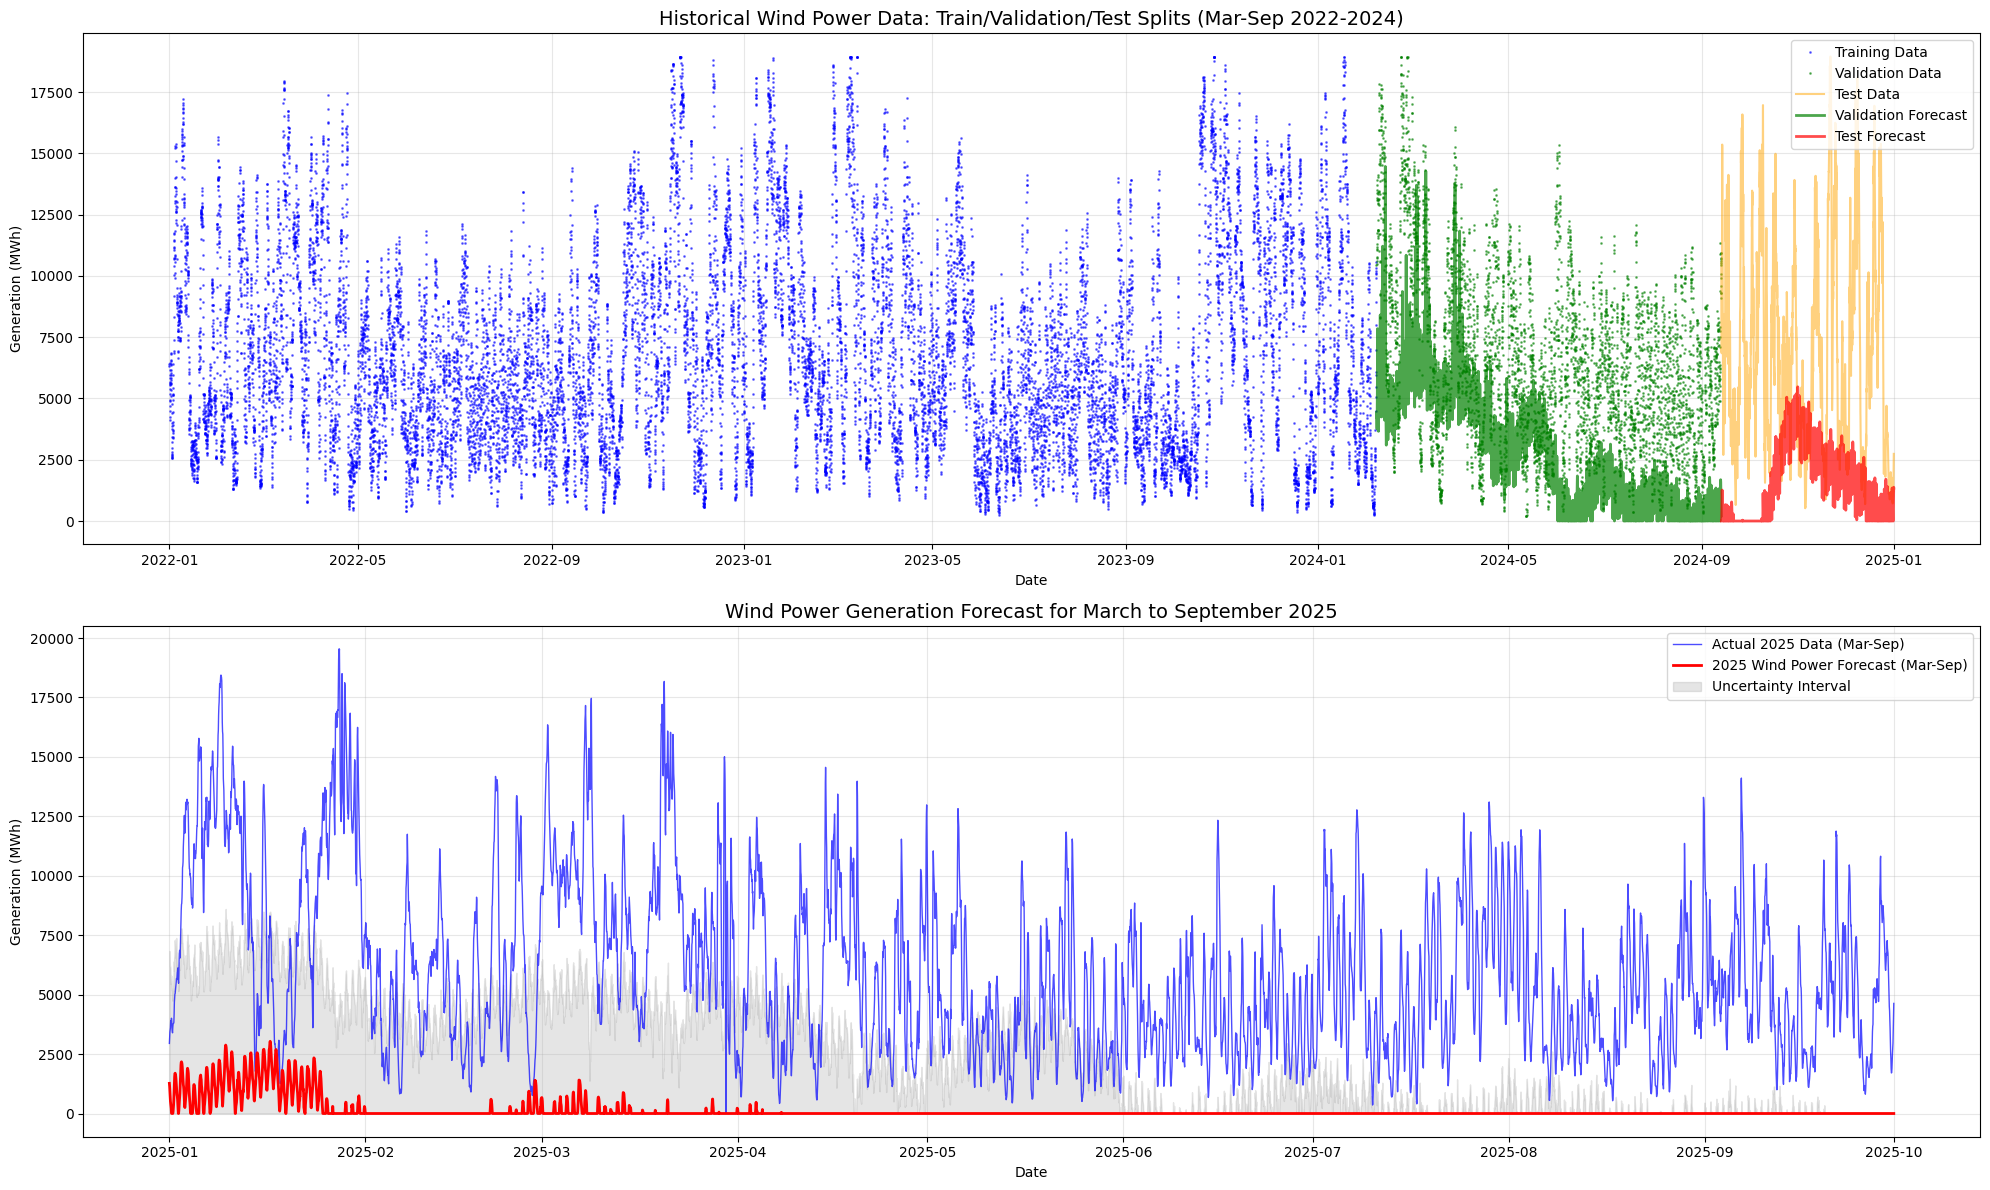

In [290]:
# Visualize train/val/test splits and model performance for wind power
fig, axes = plt.subplots(2, 1, figsize=(20, 12))

# Plot 1: Historical data with splits (Mar-Sep 2022-2024)
ax1 = axes[0]
ax1.plot(train_df['ds'], train_df['y'], 'b.', label='Training Data', alpha=0.5, markersize=2)
ax1.plot(val_df['ds'], val_df['y'], 'g.', label='Validation Data', alpha=0.5, markersize=2)
ax1.plot(test_df['ds'], test_df['y'], 'orange', label='Test Data', alpha=0.5, markersize=2)

# Add predictions on validation and test sets
ax1.plot(val_forecast['ds'], val_forecast['yhat'], 'g-', label='Validation Forecast', linewidth=2, alpha=0.7)
ax1.plot(test_forecast['ds'], test_forecast['yhat'], 'r-', label='Test Forecast', linewidth=2, alpha=0.7)

ax1.set_title('Historical Wind Power Data: Train/Validation/Test Splits (Mar-Sep 2022-2024)', fontsize=14)
ax1.set_xlabel('Date')
ax1.set_ylabel('Generation (MWh)')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Plot 2: 2025 Forecast (Mar-Sep)
ax2 = axes[1]
ax2.plot(df_2025['ds'], df_2025['y'], 'b-', label='Actual 2025 Data (Mar-Sep)', linewidth=1, alpha=0.7)
ax2.plot(forecast_2025['ds'], forecast_2025['yhat'], 'r-', label='2025 Wind Power Forecast (Mar-Sep)', linewidth=2)
ax2.fill_between(forecast_2025['ds'],
                 forecast_2025['yhat_lower'],
                 forecast_2025['yhat_upper'],
                 color='gray',
                 alpha=0.2,
                 label='Uncertainty Interval')

ax2.set_title('Wind Power Generation Forecast for March to September 2025', fontsize=14)
ax2.set_xlabel('Date')
ax2.set_ylabel('Generation (MWh)')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



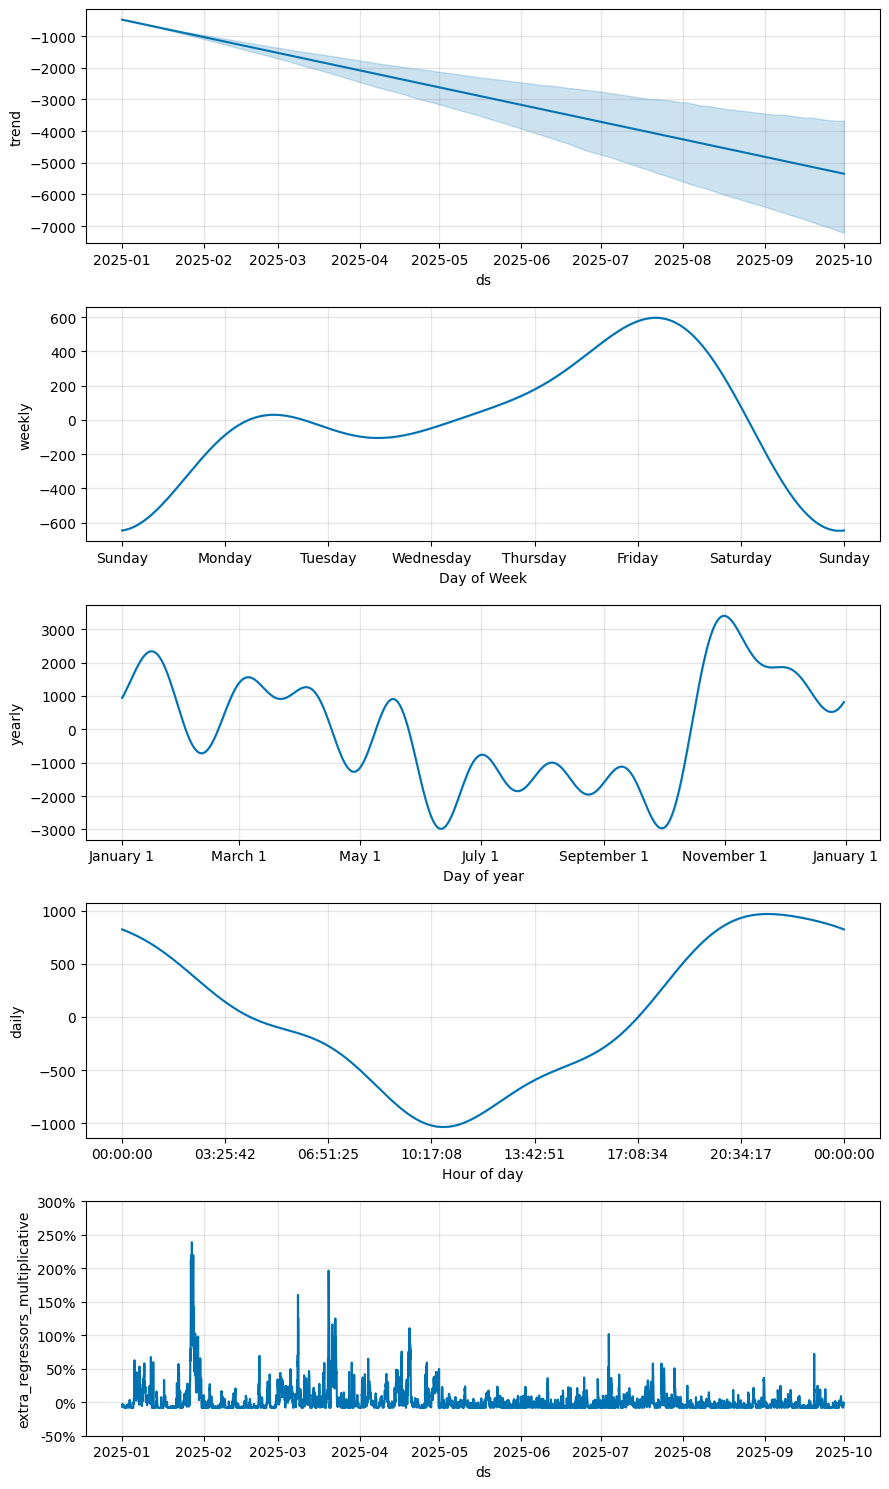

In [291]:
# Show seasonal components
fig = model.plot_components(forecast_2025)
plt.tight_layout()
plt.show()